# Problem statement: Wind power forecasting for the next 72 hours.
### What is wind power?
     The conversion of the wind when it touches the wind turbine at a determined speed making the blades to rotate that is mechanical energy into electrical energy.
### What are the types of wind turbine:
    There are two types of wind turbine:
    Based on the structure:
        1.Horizontal axis
        2.Vertical axis
    Based on the location:
        1. Offshore wind turbine 
        2. Onshore wind turbine
    Based on the wind speed :
        1. CLASS-I (<10m/s)
        2. CLASS-II (12m/s)
        3. CLASS-III(16 m/s)
 
## The wind turbine power curve deponds on the following conditions:
  ### 1. Wind conditions at the site :
      The weather conditions such as weather the place is humid,hot or cold which affects the wind speed and also the turbulance of the wind.
  ### 2. Air density: 
      The pressure and temerature of the site.
  ### 3. Condition of the turbine :
      The turbine whether it is new or old as the age of the turbine increases the power generated from the turbine also decreases.
## What are the main parameters finally required for prediction
       i) Whether the wind turbine is offshore or onshore, it does not matter as the wind turbine power mainly deponds on the wind speed alone. 
       ii) The Horizontal axis turbine are mostly preferred in comparison with the vertical axis.
       iii) The temperature,air pressure all are important and the wind speed deponds on the location , the power output in turn deponds on the wind speed. The altitude and latitude , the blade length and the height of the hub are other parameters.
       In this problem since we are trying to predict the wind power based on the weather condition alone. we will focus on the 
           1. wind speed (m/s)
           2. Air temperature
           3. Pressure 
           4. Wind direction 
        
    

# Import the required libraries


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from math import sqrt
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

# Import the dataset


In [88]:
dataset=pd.read_excel('C:\\Users\\HP-PC\\Desktop\\IBM HACKATHON\\AL_WIND_07_12.xlsx')

## DATA UNDERSTANDING AND CLEANING

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 6 columns):
DateTime                            52560 non-null datetime64[ns]
Air temperature | ('C)              52560 non-null float64
Pressure | (atm)                    52560 non-null float64
Wind speed | (m/s)                  52560 non-null float64
Wind direction | (deg)              52560 non-null int64
Power generated by system | (kW)    52560 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 2.4 MB


This shows that there is no null values. There are 52560 observations present. Even though there is no missing values .The wind speed must be greater the 3m/s for the power production .The turbines which power home or small turbines which can function in lesser speed but in case of power production for electricity grid, it has to be greater than 3m/s .So, we drop those rows which has wind speed lesser than 3m/s

In [89]:
dataset=dataset[dataset['Wind speed | (m/s)']>3]
print("Number of observations present is :",len(dataset))

Number of observations present is : 42612


The wind speed should not exceed 25m/s as it might damage the turbine ,but we dont have any observations greater than 20m/s so, its fine. But there are observations where even though the wind speed is greater than 3m/s the power generated is zero. Which shows that in those cases the turbine was not working.

In [90]:
POWER_OUTPUT_ZERO=dataset[dataset['Power generated by system | (kW)']==0]
print("Number of observations present is :",len(POWER_OUTPUT_ZERO))

Number of observations present is : 3646


In [12]:
#There are 5 years of data
pd.to_datetime(dataset['DateTime']).dt.year.unique()

array([2007, 2008, 2009, 2010, 2011, 2012], dtype=int64)

In [91]:
# we will add datetime info from the datetime column
#we will create column for seperate date 
dataset['Date']=pd.to_datetime(dataset['DateTime']).dt.date
dataset['year']=pd.to_datetime(dataset['DateTime']).dt.year
dataset['weakday']=pd.to_datetime(dataset['DateTime']).dt.week
dataset['month']=pd.to_datetime(dataset['DateTime']).dt.month
dataset['Day']=pd.to_datetime(dataset['DateTime']).dt.day_name()
dataset['time']=pd.to_datetime(dataset['DateTime']).dt.time
dataset['Hour']=pd.to_datetime(dataset['DateTime']).dt.hour
dataset['Power generated by system | (kW)']=dataset['Power generated by system | (kW)']/1000

# DATA VISUALIZATION

Text(0, 0.5, 'Power generated by system | (MW)')

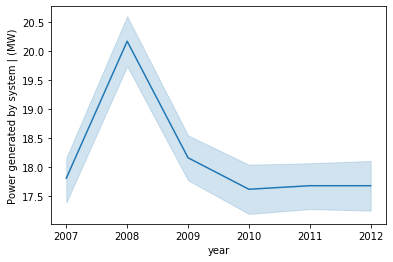

In [19]:
# The power generation for all the years
sns.lineplot(dataset['year'],dataset['Power generated by system | (kW)'])
plt.ylabel('Power generated by system | (MW)')

2008-The power is very high in the year 2008 because in USA , more than 25 new wind turbines were installed and USA stood number one in that year, in the power production. 
2011-The power is lesser in 2010 cause due to their energy cost and some internal reasons there was lesser power production from wind energy.

C:\Users\HP-PC\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1, 'power generation distribution of year 2009')

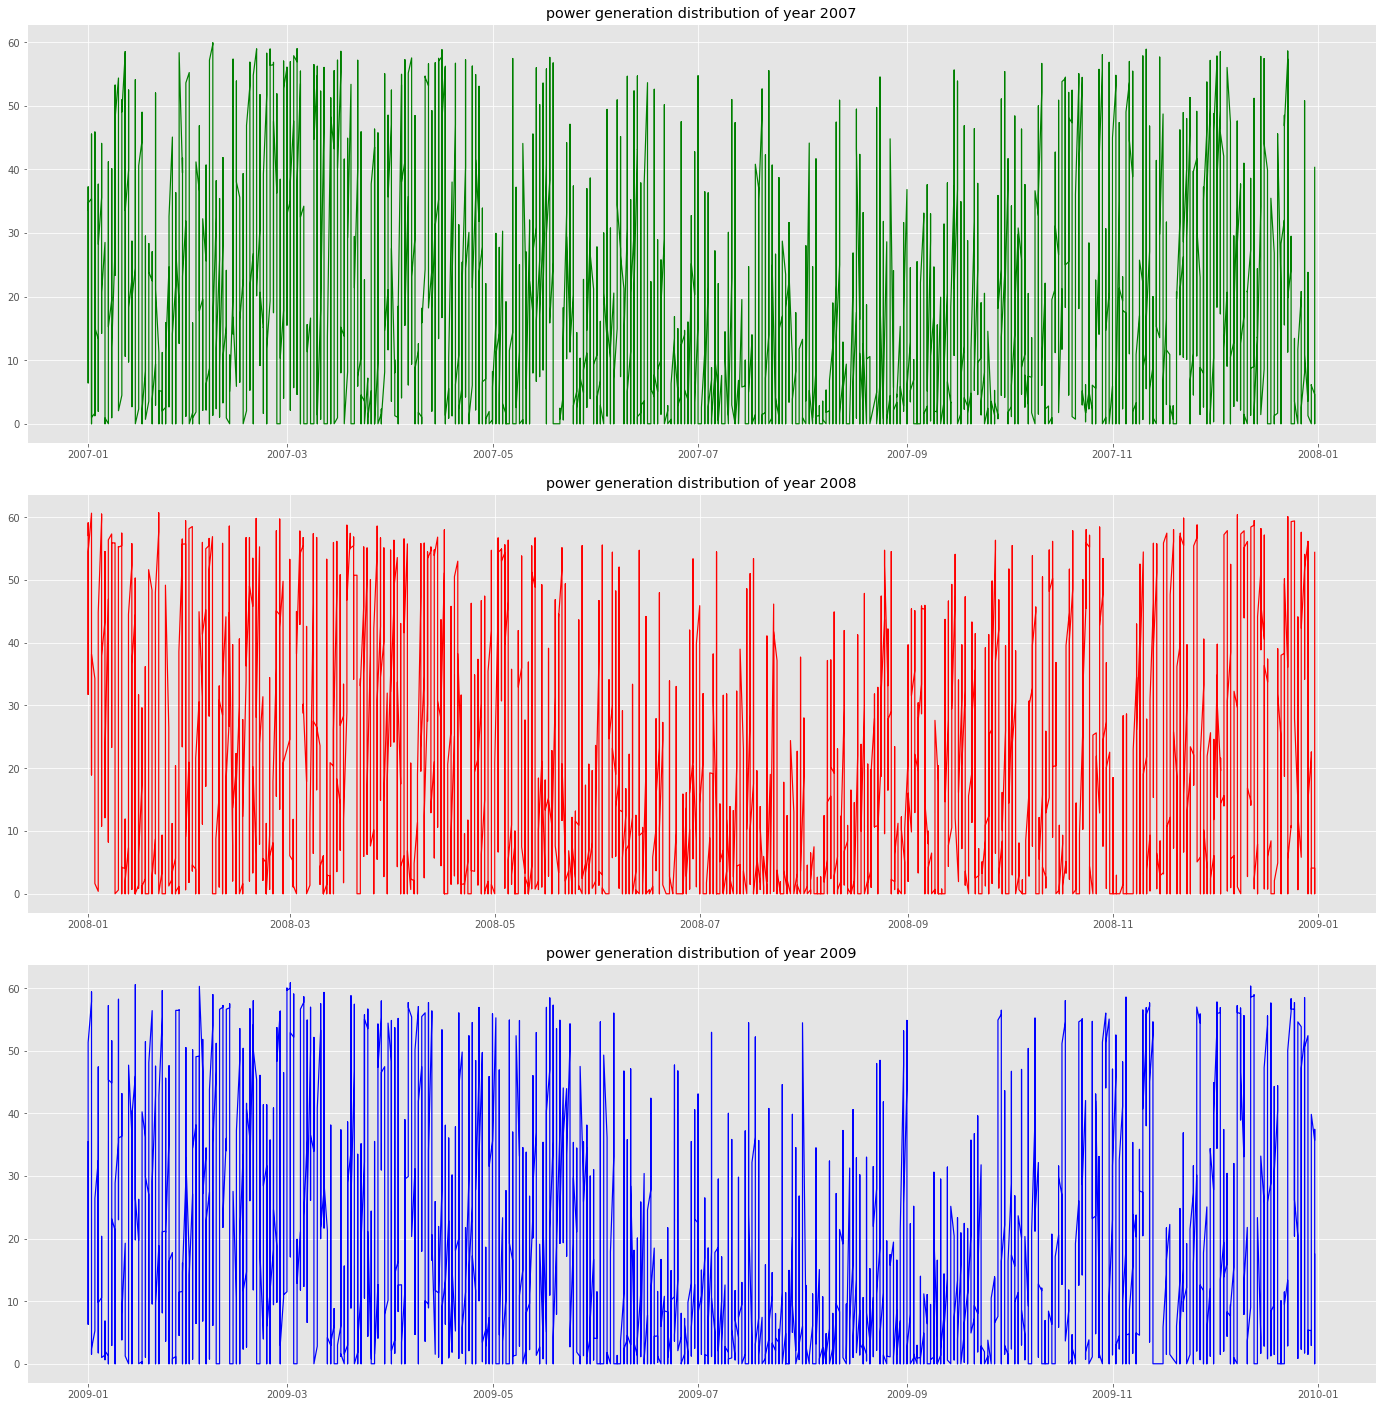

In [34]:
#Distribution per year
fig=plt.figure(figsize=(20,20))
style.use("ggplot")
ax1=fig.add_subplot(3,1,1)
ax2=fig.add_subplot(3,1,2)
ax3=fig.add_subplot(3,1,3)
fig. tight_layout(pad=3.0)
y_year_2007=dataset[dataset['year']==2007]['Power generated by system | (kW)'].to_list()
x_year_2007=dataset[dataset['year']==2007]['Date'].to_list()
ax1.plot(x_year_2007,y_year_2007,color='Green',linewidth=1.2)
ax1.title.set_text("power generation distribution of year 2007")
y_year_2008=dataset[dataset['year']==2008]['Power generated by system | (kW)'].to_list()
x_year_2008=dataset[dataset['year']==2008]['Date'].to_list()
ax2.plot(x_year_2008,y_year_2008,color='red',linewidth=1.2)
ax2.title.set_text("power generation distribution of year 2008")
y_year_2009=dataset[dataset['year']==2009]['Power generated by system | (kW)'].to_list()
x_year_2009=dataset[dataset['year']==2009]['Date'].to_list()
ax3.plot(x_year_2009,y_year_2009,color='blue',linewidth=1.2)
plt.grid(True,alpha=1)
plt.title("power generation distribution of year 2009")

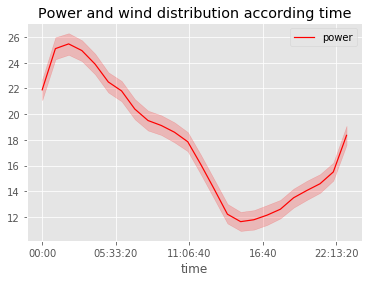

In [35]:
#distribution according to time
power=dataset['Power generated by system | (kW)'].to_list()
#wind=dataset['Wind speed | (m/s)'].to_list()
time=dataset['time'].to_list()
sns.lineplot(time,power,color='red',linewidth=1.2)
#sns.lineplot(time,wind,color='black',linewidth=1.2)
plt.title('Power and wind distribution according time')
plt.legend(labels=['power'])

It makes sense since it is offshore turbine and the power production is higer in the night when compared to the day time.

Text(0.5, 1.0, 'Wind speed distribution based on the direction')

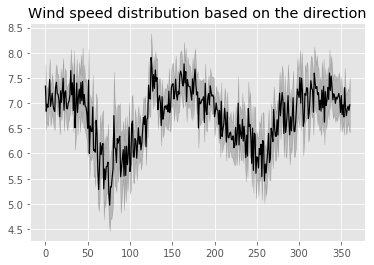

In [36]:
wind=dataset['Wind speed | (m/s)'].to_list()
winddir=dataset['Wind direction | (deg)'].to_list()
sns.lineplot(winddir,wind,color='black',linewidth=1.2)
plt.title('Wind speed distribution based on the direction')

0 degree is north 90 degree is east and south is 180 so , the wind speed is maximum in the south east direction

# correlation 

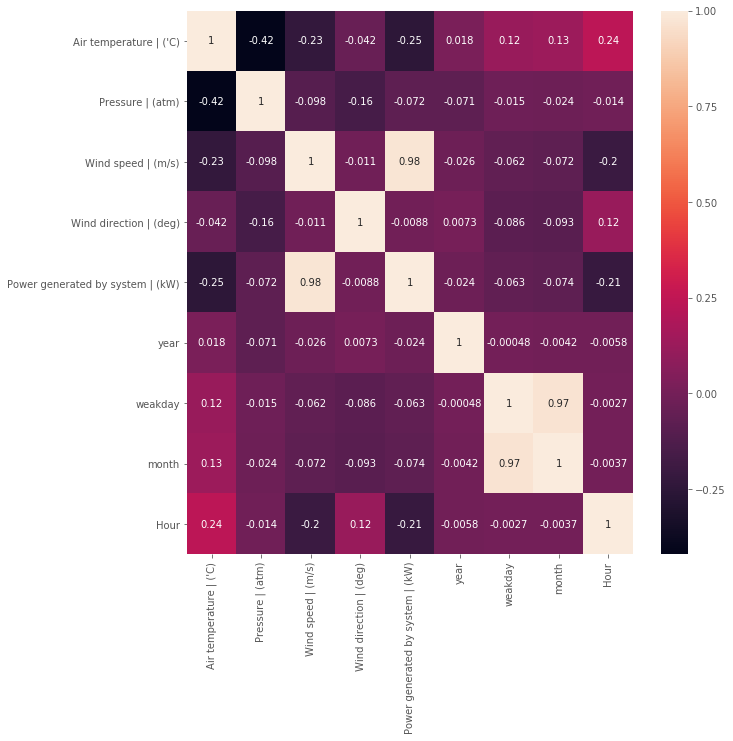

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr(),annot=True)

COMPONENTS OF TIME SERIES:
    1. Trend :The increase or decrease pattern in the case of the time series
    2. Seasonality: The observations has repeating pattern
    3. Noise :If the series is completely random it cannot be predicted, so it has to be checked for random walk.

# CHECKING FOR STATIONARITY


In [44]:
def checking_for_stationary(series,name='',verbose=False):
    r=adfuller(series,autolag='AIC')
    print("The test summary for checking if the series is stationary test or not ")
    print(f' Test Statistic        = {r[0]}')
    print(f' No. Lags Chosen       = {r[2]}')
    print("adfuller test on ",name)
    for key,val in r[4].items():
        print(f' Critical value {(key)} = {round(val, 3)}')

    if r[0] <= r[4]["5%"]:
        print(f" => P-Value = {r[1]}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    if r[0]>r[4]["5%"]:
        print(f" => P-Value = {r[1]}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 
        

In [47]:
dataset=pd.read_excel('C:\\Users\\HP-PC\\Desktop\\IBM HACKATHON\\AL_WIND_07_12.xlsx',index_col='DateTime')
for name,cols in dataset.iteritems():
    checking_for_stationary (cols,name=cols.name)
    print("\n")

The test summary for checking if the series is stationary test or not 
 Test Statistic        = -8.337628759730313
 No. Lags Chosen       = 57
adfuller test on  Air temperature | ('C)
 Critical value 1% = -3.43
 Critical value 5% = -2.862
 Critical value 10% = -2.567
 => P-Value = 3.2400235194706116e-13. Rejecting Null Hypothesis.
 => Series is Stationary.


The test summary for checking if the series is stationary test or not 
 Test Statistic        = -16.12145274831609
 No. Lags Chosen       = 57
adfuller test on  Pressure | (atm)
 Critical value 1% = -3.43
 Critical value 5% = -2.862
 Critical value 10% = -2.567
 => P-Value = 4.8927211810402126e-29. Rejecting Null Hypothesis.
 => Series is Stationary.


The test summary for checking if the series is stationary test or not 
 Test Statistic        = -22.936318350611742
 No. Lags Chosen       = 57
adfuller test on  Wind speed | (m/s)
 Critical value 1% = -3.43
 Critical value 5% = -2.862
 Critical value 10% = -2.567
 => P-Value = 0.0. 

we will use LSTM to forecast. LSTM stands for long short term memory which is a type of recurrent neural network. This network is widely used for time series. In the case of time series especially for the neural network the observations need not be compulsorly be stationary, it can be non-stationary also. But from the above test it shows that our dataset is stationary .Even though there are some requirements for correction but in this project i did not go to much into checking since lstm has gives reasonable accuracy without correction

In [48]:
# The time series has to be converted to supervised learning:
def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [49]:
# LSTM uses tangent function so, it is best to give the observations in the range (-1,1)
def scaling(data):
    scale=MinMaxScaler(feature_range=(-1,1))
    scale=scale.fit(data)
    scaled_data=scale.transform(data)
    return scale,scaled_data

In [50]:
def inverse_scaling(scale,data):
    return (scale.inverse_transform(data))
    
    

In [51]:
def lstm_model(train):
    x, y =  train[:, :-1], train[:, -1]
    epochs=1
    X=x.reshape((x.shape[0],1,x.shape[1]))
    model=Sequential()
    model.add(LSTM(100,input_shape=( X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X,y,epochs=10,batch_size=100,verbose=1, shuffle=False)
    return model
    

In [92]:
# we will take the dataset from the year 2010 
# for training the 2010 to 2012 and the last 72 hours for testing
dataset=dataset[dataset['year']>2009]
dataset=dataset[['Wind speed | (m/s)','''Air temperature | ('C)''', 'Pressure | (atm)','Wind direction | (deg)','Power generated by system | (kW)']]
dataset=dataset.values
scale,train_scaled=scaling(dataset)
#dataset.head()

In [94]:
data=series_to_supervised(train_scaled,1,1)
data=data.drop(['var1(t)','var2(t)','var3(t)','var4(t)'],axis=1)

In [95]:
train,test=data[:-72],data[-72:]
train_array=np.asarray(train)
test_array=np.asarray(test)

In [96]:
model=lstm_model(train_array)

Epoch 1/10
20898/20898 [==============================] - 3s 133us/step - loss: 0.1431
Epoch 2/10
20898/20898 [==============================] - 1s 52us/step - loss: 0.0610
Epoch 3/10
20898/20898 [==============================] - 1s 59us/step - loss: 0.0595
Epoch 4/10
20898/20898 [==============================] - 2s 78us/step - loss: 0.0594
Epoch 5/10
20898/20898 [==============================] - 1s 55us/step - loss: 0.0592
Epoch 6/10
20898/20898 [==============================] - 1s 54us/step - loss: 0.0591
Epoch 7/10
20898/20898 [==============================] - 1s 53us/step - loss: 0.0593
Epoch 8/10
20898/20898 [==============================] - 1s 54us/step - loss: 0.0594
Epoch 9/10
20898/20898 [==============================] - 1s 54us/step - loss: 0.0593
Epoch 10/10
20898/20898 [==============================] - 1s 59us/step - loss: 0.0593


In [97]:
x_test,y_test=test_array[:,:-1],test_array[:,-1]
x_test=x_test.reshape(x_test.shape[0],1,x_test.shape[1])
prediction=model.predict(x_test)

In [98]:
x_test = x_test.reshape((x_test.shape[0], x_test.shape[2]))

In [99]:
inversed_pred= np.concatenate((prediction, x_test[:, 1:]), axis=1)

In [100]:
#inverse scaling
inversed_scaled_pred=inverse_scaling(scale,inversed_pred)

In [101]:
#inverse scaling for actual values
y_test = y_test.reshape((len(y_test), 1))
inverted_actual =np.concatenate((y_test,x_test[:, 1:]), axis=1)
inverted_actual_scaled= inverse_scaling(scale,inverted_actual)

In [102]:
print("Mean squared error: %.3f" % mean_squared_error(inverted_actual_scaled[:,0],inversed_scaled_pred[:,0]))

Mean squared error: 1.926


In [103]:
sqrt(mean_squared_error(inverted_actual_scaled[:,0],inversed_scaled_pred[:,0]))

1.3876245061448733

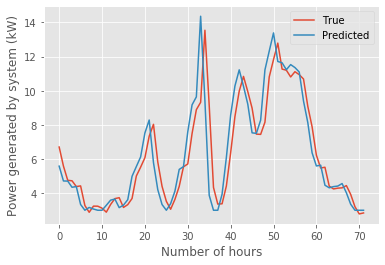

In [105]:
plt.plot(inversed_scaled_pred[:,0], label="True")
plt.plot(inverted_actual_scaled[:,0], label="Predicted")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("Power generated by system (kW)")
plt.show()
